# Notes 2 - Predictors of recorded DS live births

- Train from 2016 and ignore no_congen


## Preparation


In [13]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0007-predictors-5/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-26T09:38:58.500927
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 56 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0007-predictors-5/20251226-093858
--------------------



### Options


In [14]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.6
VALIDATION_SPLIT = 0.2
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 20
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [ ]:
df = data_utils.load_predictors_data(
    from_year=START_YEAR, to_year=END_YEAR, include_unknown=True
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [16]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    # "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"].replace({pd.NA: 0, np.nan: 0}).astype(np.int32)

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [17]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [18]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 13428567 negatives, 7124 positives, probability positive 0.00053051
Validation set: 13428568 negatives, 7123 positives, probability positive 0.00053044
Calibration set: 6714284 negatives, 3562 positives, probability positive 0.00053051


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.014424944085355594,
    "num_leaves": 49,
    "min_data_in_leaf": 876,
    "min_gain_to_split": 0.8308801865902878,
    "feature_fraction": 0.6394237903140767,
    "bagging_fraction": 0.7660617255683487,
    "bagging_freq": 8,
    "lambda_l1": 0.0025952143941036176,
    "lambda_l2": 0.3152288963060601,
}

## Hyperparameter tuning


In [20]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-26 09:40:33,471] A new study created in memory with name: no-name-2fbae1b9-acc6-400f-84dd-ef59b64bfc74


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0245714	valid_0's binary_logloss: 0.00396615
[20]	valid_0's average_precision: 0.0262445	valid_0's binary_logloss: 0.00383559
[30]	valid_0's average_precision: 0.0272719	valid_0's binary_logloss: 0.003766
[40]	valid_0's average_precision: 0.0277567	valid_0's binary_logloss: 0.0037186
[50]	valid_0's average_precision: 0.0281231	valid_0's binary_logloss: 0.00368763
[60]	valid_0's average_precision: 0.0284201	valid_0's binary_logloss: 0.00366634
[70]	valid_0's average_precision: 0.0285335	valid_0's binary_logloss: 0.00365284
[80]	valid_0's average_precision: 0.02

[I 2025-12-26 09:44:04,597] Trial 0 finished with value: 0.028845946164767565 and parameters: {'learning_rate': 0.027837755314308335, 'num_leaves': 219, 'min_data_in_leaf': 2012, 'min_gain_to_split': 0.10130869304800072, 'feature_fraction': 0.7750919787419004, 'bagging_fraction': 0.9946558910328149, 'bagging_freq': 3, 'lambda_l1': 8.101687869334844e-08, 'lambda_l2': 6.426101895586728e-07}. Best is trial 0 with value: 0.028845946164767565.


Early stopping, best iteration is:
[92]	valid_0's average_precision: 0.0288459	valid_0's binary_logloss: 0.00363488
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0068783	valid_0's binary_logloss: 0.00711337
[20]	valid_0's average_precision: 0.00508477	valid_0's binary_logloss: 0.00671334


[I 2025-12-26 09:44:34,384] Trial 1 finished with value: 0.02247555923975162 and parameters: {'learning_rate': 0.23814749844842847, 'num_leaves': 133, 'min_data_in_leaf': 553, 'min_gain_to_split': 0.36800995354402666, 'feature_fraction': 0.9193907404610275, 'bagging_fraction': 0.831097561554188, 'bagging_freq': 3, 'lambda_l1': 6.3551943103429455e-06, 'lambda_l2': 0.01457635152163626}. Best is trial 0 with value: 0.028845946164767565.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0224756	valid_0's binary_logloss: 0.0277407
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0260892	valid_0's binary_logloss: 0.004155
[20]	valid_0's average_precision: 0.0274294	valid_0's binary_logloss: 0.00401613
[30]	valid_0's average_precision: 0.02797	valid_0's binary_logloss: 0.0039411
[40]	valid_0's average_precision: 0.0285526	valid_0's binary_logloss: 0.0038749
[50]	valid_0's average_precision: 0.0290196	valid_0's binary_logloss: 0.00382598
[60]	valid_0's average_precision: 0.0292647	valid_0's binary_logloss: 0.00378648
[70]	val

[I 2025-12-26 09:51:58,331] Trial 2 finished with value: 0.03132116872460939 and parameters: {'learning_rate': 0.014112894968782432, 'num_leaves': 33, 'min_data_in_leaf': 1387, 'min_gain_to_split': 0.8533968869364915, 'feature_fraction': 0.6692791233596806, 'bagging_fraction': 0.8888577900485188, 'bagging_freq': 6, 'lambda_l1': 7.454713703171549e-07, 'lambda_l2': 0.05354924789925241}. Best is trial 2 with value: 0.03132116872460939.


Early stopping, best iteration is:
[278]	valid_0's average_precision: 0.0313212	valid_0's binary_logloss: 0.00361373
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:52:01,258] Trial 3 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0158329	valid_0's binary_logloss: 0.00475521
[20]	valid_0's average_precision: 0.0185856	valid_0's binary_logloss: 0.00459343
[30]	valid_0's average_precision: 0.0178963	valid_0's binary_logloss: 0.00458919


[I 2025-12-26 09:53:01,435] Trial 4 finished with value: 0.018585569536729105 and parameters: {'learning_rate': 0.17777488983639617, 'num_leaves': 78, 'min_data_in_leaf': 6192, 'min_gain_to_split': 0.2667039224675005, 'feature_fraction': 0.7839644262783588, 'bagging_fraction': 0.9296479252756886, 'bagging_freq': 8, 'lambda_l1': 0.01214615414554779, 'lambda_l2': 4.2100489133423584e-07}. Best is trial 2 with value: 0.03132116872460939.


[40]	valid_0's average_precision: 0.0173487	valid_0's binary_logloss: 0.00459403
Early stopping, best iteration is:
[20]	valid_0's average_precision: 0.0185856	valid_0's binary_logloss: 0.00459343
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:05,133] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:15,115] Trial 6 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:17,560] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:21,170] Trial 8 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:23,635] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:28,742] Trial 10 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 09:53:32,005] Trial 11 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0247087	valid_0's binary_logloss: 0.00398896
[20]	valid_0's average_precision: 0.0265425	valid_0's binary_logloss: 0.00385317
[30]	valid_0's average_precision: 0.0273776	valid_0's binary_logloss: 0.00378389
[40]	valid_0's average_precision: 0.0280468	valid_0's binary_logloss: 0.00373211
[50]	valid_0's average_precision: 0.0284346	valid_0's binary_logloss: 0.00369728
[60]	valid_0's average_precision: 0.0287954	valid_0's binary_logloss: 0.00367289
[70]	valid_0's average_precision: 0.0289981	valid_0's binary_logloss: 0.00365728
[80]	valid_0's average_precision: 0

[I 2025-12-26 09:57:08,122] Trial 12 finished with value: 0.029518247911713532 and parameters: {'learning_rate': 0.027871672222574435, 'num_leaves': 73, 'min_data_in_leaf': 1410, 'min_gain_to_split': 0.7002132088896336, 'feature_fraction': 0.7123903839674193, 'bagging_fraction': 0.9990656804446318, 'bagging_freq': 10, 'lambda_l1': 5.483686213161703e-07, 'lambda_l2': 0.0014073674149775652}. Best is trial 2 with value: 0.03132116872460939.


Early stopping, best iteration is:
[142]	valid_0's average_precision: 0.0295182	valid_0's binary_logloss: 0.00361733
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0247214	valid_0's binary_logloss: 0.00402983
[20]	valid_0's average_precision: 0.0265202	valid_0's binary_logloss: 0.00389064
[30]	valid_0's average_precision: 0.0274451	valid_0's binary_logloss: 0.00381705
[40]	valid_0's average_precision: 0.0280607	valid_0's binary_logloss: 0.00376051
[50]	valid_0's average_precision: 0.0284347	valid_0's binary_logloss: 0.00372237
[60]	valid_0's average_precision: 0.0288305	valid_0's binary_logloss: 0.00369321

[I 2025-12-26 10:02:19,063] Trial 13 finished with value: 0.02989019096030023 and parameters: {'learning_rate': 0.023850443191337244, 'num_leaves': 63, 'min_data_in_leaf': 1173, 'min_gain_to_split': 0.7099580314396124, 'feature_fraction': 0.6888234766658297, 'bagging_fraction': 0.897397368089834, 'bagging_freq': 10, 'lambda_l1': 3.2018732128845387e-06, 'lambda_l2': 0.001709195611003257}. Best is trial 2 with value: 0.03132116872460939.


Early stopping, best iteration is:
[213]	valid_0's average_precision: 0.0298902	valid_0's binary_logloss: 0.00361071
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0226392	valid_0's binary_logloss: 0.00417096
[20]	valid_0's average_precision: 0.0256869	valid_0's binary_logloss: 0.00400199
[30]	valid_0's average_precision: 0.0271699	valid_0's binary_logloss: 0.00391823
[40]	valid_0's average_precision: 0.0281881	valid_0's binary_logloss: 0.00384561
[50]	valid_0's average_precision: 0.0288587	valid_0's binary_logloss: 0.00379561
[60]	valid_0's average_precision: 0.0292639	valid_0's binary_logloss: 0.00375736

[I 2025-12-26 10:07:57,000] Trial 14 finished with value: 0.03165695175408869 and parameters: {'learning_rate': 0.01781782620122254, 'num_leaves': 49, 'min_data_in_leaf': 990, 'min_gain_to_split': 0.686265297766877, 'feature_fraction': 0.6063775983825287, 'bagging_fraction': 0.90198247327058, 'bagging_freq': 10, 'lambda_l1': 1.9397261441273576e-06, 'lambda_l2': 3.879598081956682}. Best is trial 14 with value: 0.03165695175408869.


Early stopping, best iteration is:
[232]	valid_0's average_precision: 0.031657	valid_0's binary_logloss: 0.00360916
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:08:06,989] Trial 15 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0259	valid_0's binary_logloss: 0.00416327
[20]	valid_0's average_precision: 0.0274482	valid_0's binary_logloss: 0.00401714
[30]	valid_0's average_precision: 0.028	valid_0's binary_logloss: 0.00393818
[40]	valid_0's average_precision: 0.0288345	valid_0's binary_logloss: 0.0038709
[50]	valid_0's average_precision: 0.0294083	valid_0's binary_logloss: 0.00382086
[60]	valid_0's average_precision: 0.0298381	valid_0's binary_logloss: 0.00378118
[70]	valid_0's average_precision: 0.0299982	valid_0's binary_logloss: 0.00375434
[80]	valid_0's average_precision: 0.0301297

[I 2025-12-26 10:16:02,962] Trial 16 finished with value: 0.031755599119473336 and parameters: {'learning_rate': 0.014424944085355594, 'num_leaves': 49, 'min_data_in_leaf': 876, 'min_gain_to_split': 0.8308801865902878, 'feature_fraction': 0.6394237903140767, 'bagging_fraction': 0.7660617255683487, 'bagging_freq': 8, 'lambda_l1': 0.0025952143941036176, 'lambda_l2': 0.3152288963060601}. Best is trial 16 with value: 0.031755599119473336.


Early stopping, best iteration is:
[349]	valid_0's average_precision: 0.0317556	valid_0's binary_logloss: 0.00360295
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:05,058] Trial 17 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:13,934] Trial 18 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:16,275] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:20,292] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:24,017] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:26,165] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:28,120] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:16:32,448] Trial 24 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0251818	valid_0's binary_logloss: 0.00405175
[20]	valid_0's average_precision: 0.0272429	valid_0's binary_logloss: 0.00391432
[30]	valid_0's average_precision: 0.0280974	valid_0's binary_logloss: 0.0038356
[40]	valid_0's average_precision: 0.0287722	valid_0's binary_logloss: 0.00377952
[50]	valid_0's average_precision: 0.0291759	valid_0's binary_logloss: 0.00373957
[60]	valid_0's average_precision: 0.0294786	valid_0's binary_logloss: 0.00370992
[70]	valid_0's average_precision: 0.029711	valid_0's binary_logloss: 0.00368931
[80]	valid_0's average_precision: 0.0

[I 2025-12-26 10:20:54,121] Trial 25 finished with value: 0.03099220959359292 and parameters: {'learning_rate': 0.02183958709726696, 'num_leaves': 32, 'min_data_in_leaf': 1128, 'min_gain_to_split': 0.829720280945585, 'feature_fraction': 0.7214566886355482, 'bagging_fraction': 0.789066313666048, 'bagging_freq': 9, 'lambda_l1': 3.916875641068302e-05, 'lambda_l2': 0.01106069437668005}. Best is trial 16 with value: 0.031755599119473336.


Early stopping, best iteration is:
[202]	valid_0's average_precision: 0.0309922	valid_0's binary_logloss: 0.00361248
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:21:03,456] Trial 26 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0268362	valid_0's binary_logloss: 0.00413945
[20]	valid_0's average_precision: 0.0279217	valid_0's binary_logloss: 0.00400007
[30]	valid_0's average_precision: 0.0285257	valid_0's binary_logloss: 0.00391989
[40]	valid_0's average_precision: 0.0291245	valid_0's binary_logloss: 0.00385753
[50]	valid_0's average_precision: 0.0295431	valid_0's binary_logloss: 0.00381202
[60]	valid_0's average_precision: 0.0297891	valid_0's binary_logloss: 0.00377593
[70]	valid_0's average_precision: 0.0300193	valid_0's binary_logloss: 0.00374756
[80]	valid_0's average_precision: 0

[I 2025-12-26 10:27:07,911] Trial 27 finished with value: 0.03143601464608475 and parameters: {'learning_rate': 0.013659796947492838, 'num_leaves': 40, 'min_data_in_leaf': 1085, 'min_gain_to_split': 0.9121331671400417, 'feature_fraction': 0.8235072239201452, 'bagging_fraction': 0.8597228979419228, 'bagging_freq': 6, 'lambda_l1': 2.029962358788808e-07, 'lambda_l2': 0.17224869471792906}. Best is trial 16 with value: 0.031755599119473336.


Early stopping, best iteration is:
[283]	valid_0's average_precision: 0.031436	valid_0's binary_logloss: 0.00361109
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:27:09,864] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:27:12,100] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0271211	valid_0's binary_logloss: 0.004041
[20]	valid_0's average_precision: 0.0286502	valid_0's binary_logloss: 0.00389574
[30]	valid_0's average_precision: 0.0293604	valid_0's binary_logloss: 0.00381737
[40]	valid_0's average_precision: 0.0297618	valid_0's binary_logloss: 0.00376134
[50]	valid_0's average_precision: 0.0301706	valid_0's binary_logloss: 0.00372283
[60]	valid_0's average_precision: 0.0304628	valid_0's binary_logloss: 0.00369506
[70]	valid_0's average_precision: 0.0306098	valid_0's binary_logloss: 0.00367452
[80]	valid_0's average_precision: 0.0

[I 2025-12-26 10:30:24,172] Trial 30 finished with value: 0.03116446047968454 and parameters: {'learning_rate': 0.021587989087920863, 'num_leaves': 62, 'min_data_in_leaf': 653, 'min_gain_to_split': 0.6445692030040836, 'feature_fraction': 0.8155043498402728, 'bagging_fraction': 0.8118568843030748, 'bagging_freq': 5, 'lambda_l1': 2.4096466803564638e-06, 'lambda_l2': 0.3036916004162076}. Best is trial 16 with value: 0.031755599119473336.


Early stopping, best iteration is:
[139]	valid_0's average_precision: 0.0311645	valid_0's binary_logloss: 0.00361937
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:30:26,448] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:30:32,569] Trial 32 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.026087	valid_0's binary_logloss: 0.00419022
[20]	valid_0's average_precision: 0.0272882	valid_0's binary_logloss: 0.00406457


[I 2025-12-26 10:30:54,699] Trial 33 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:30:56,630] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:31:00,676] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:31:03,047] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0256779	valid_0's binary_logloss: 0.00407637
[20]	valid_0's average_precision: 0.0270751	valid_0's binary_logloss: 0.00394055


[I 2025-12-26 10:31:32,381] Trial 37 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:31:37,129] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:31:39,234] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:31:41,547] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0270795	valid_0's binary_logloss: 0.00403462
[20]	valid_0's average_precision: 0.0285638	valid_0's binary_logloss: 0.00389306
[30]	valid_0's average_precision: 0.0293067	valid_0's binary_logloss: 0.00381581
[40]	valid_0's average_precision: 0.0297069	valid_0's binary_logloss: 0.00375967
[50]	valid_0's average_precision: 0.0301477	valid_0's binary_logloss: 0.00372238
[60]	valid_0's average_precision: 0.0304594	valid_0's binary_logloss: 0.003695
[70]	valid_0's average_precision: 0.0306314	valid_0's binary_logloss: 0.00367502
[80]	valid_0's average_precision: 0.0

[I 2025-12-26 10:36:47,534] Trial 41 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:36:55,394] Trial 42 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:36:58,964] Trial 43 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:37:02,973] Trial 44 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:37:05,353] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:37:08,955] Trial 46 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:37:13,888] Trial 47 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 10:37:17,388] Trial 48 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-12-26 10:37:27,820] Trial 49 pruned. Trial was pruned at iteration 9.


{'learning_rate': 0.014424944085355594, 'num_leaves': 49, 'min_data_in_leaf': 876, 'min_gain_to_split': 0.8308801865902878, 'feature_fraction': 0.6394237903140767, 'bagging_fraction': 0.7660617255683487, 'bagging_freq': 8, 'lambda_l1': 0.0025952143941036176, 'lambda_l2': 0.3152288963060601} 0.031755599119473336
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.014424944085355594
  "num_leaves": 49
  "min_data_in_leaf": 876
  "min_gain_to_split": 0.8308801865902878
  "feature_fraction": 0.6394237903140767
  "bagging_fraction": 0.7660617255683487
  "bagging_freq": 8
  "lambda_l1": 0.0025952143941036176
  "lambda_l2": 0.3152288963060601
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [21]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.0298416	train's binary_logloss: 0.00414357	valid's average_precision: 0.0259	valid's binary_logloss: 0.00416327
[20]	train's average_precision: 0.0327984	train's binary_logloss: 0.00398796	valid's average_precision: 0.0274482	valid's binary_logloss: 0.00401714
[30]	train's average_precision: 0.0348313	train's binary_logloss: 0.00390109	valid's average_precision: 0.028	valid's binary_logloss: 0.00393818
[40]	train's average_precision: 0.036397	train's binary_logloss: 0.00382764	valid's average_precision: 0.0288345	valid's binary_logloss: 0.0038709
[50]	train's av

In [22]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [23]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.891111
1,Validation AP,0.031756
2,Validation log loss,0.003603
3,Precision at 10000,0.080100
4,Recall at 10000,0.112453
5,Precision (threshold=0.01),0.029635
6,Recall (threshold=0.01),0.265057


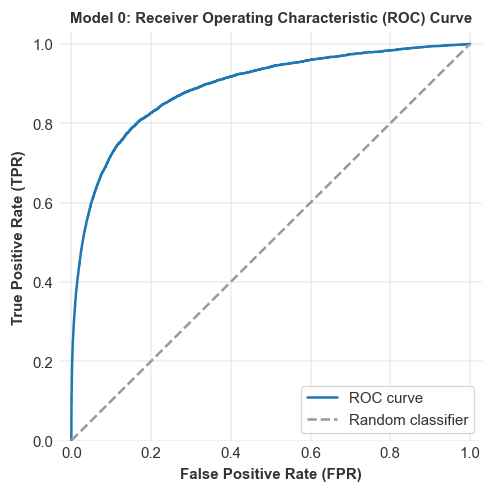

In [24]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

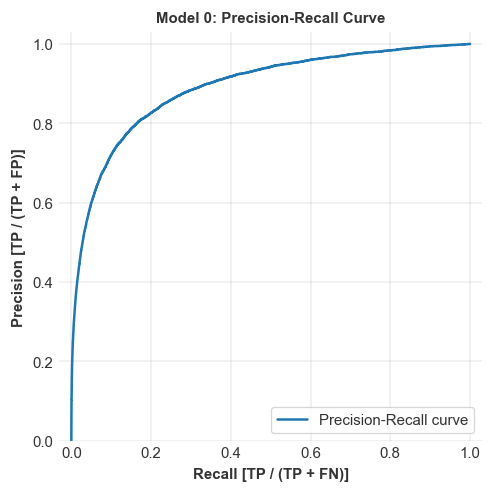

In [25]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [26]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
23,ab_nicu,207937.571504
49,mage_c,140024.563817
37,ca_disor,76174.459178
45,dbwt,64832.037624
29,ca_cchd,50489.194993
21,ab_aven1,43176.348602
5,gestrec10,35278.732331
50,fagecomb,25438.449287
47,wtgain,23409.020262
46,pwgt_r,19033.833204


### Evaluation subset for permutation importances and SHAP analysis


In [27]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [28]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [29]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
37,ca_disor,1.122277e-02,0.000378
29,ca_cchd,1.050907e-02,0.000403
49,mage_c,8.533039e-03,0.000422
45,dbwt,3.767893e-03,0.000276
23,ab_nicu,3.431623e-03,0.000559
5,gestrec10,2.067745e-03,0.000252
18,dmeth_rec,1.565578e-03,0.000269
21,ab_aven1,9.881713e-04,0.000223
47,wtgain,8.529337e-04,0.000260
22,ab_aven6,6.334884e-04,0.000089


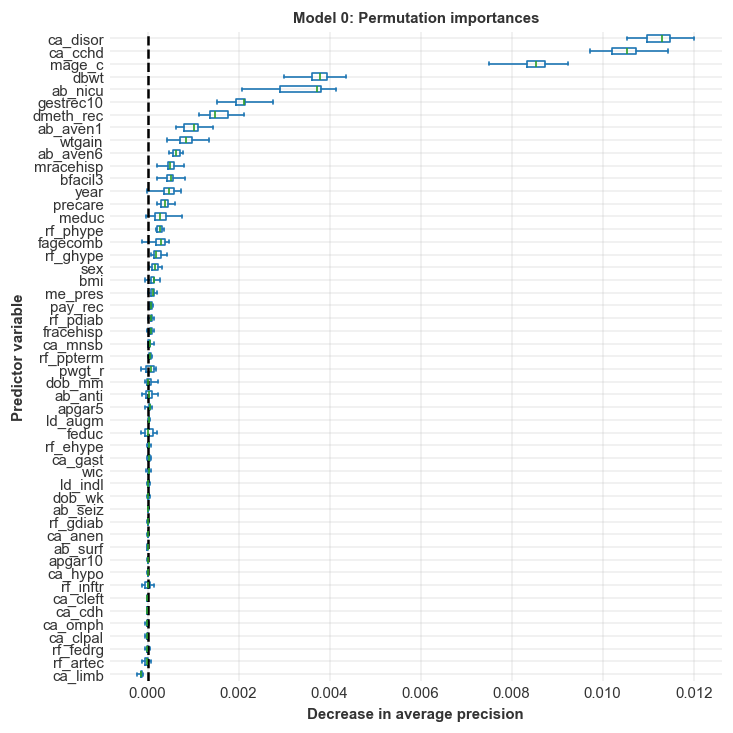

In [30]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

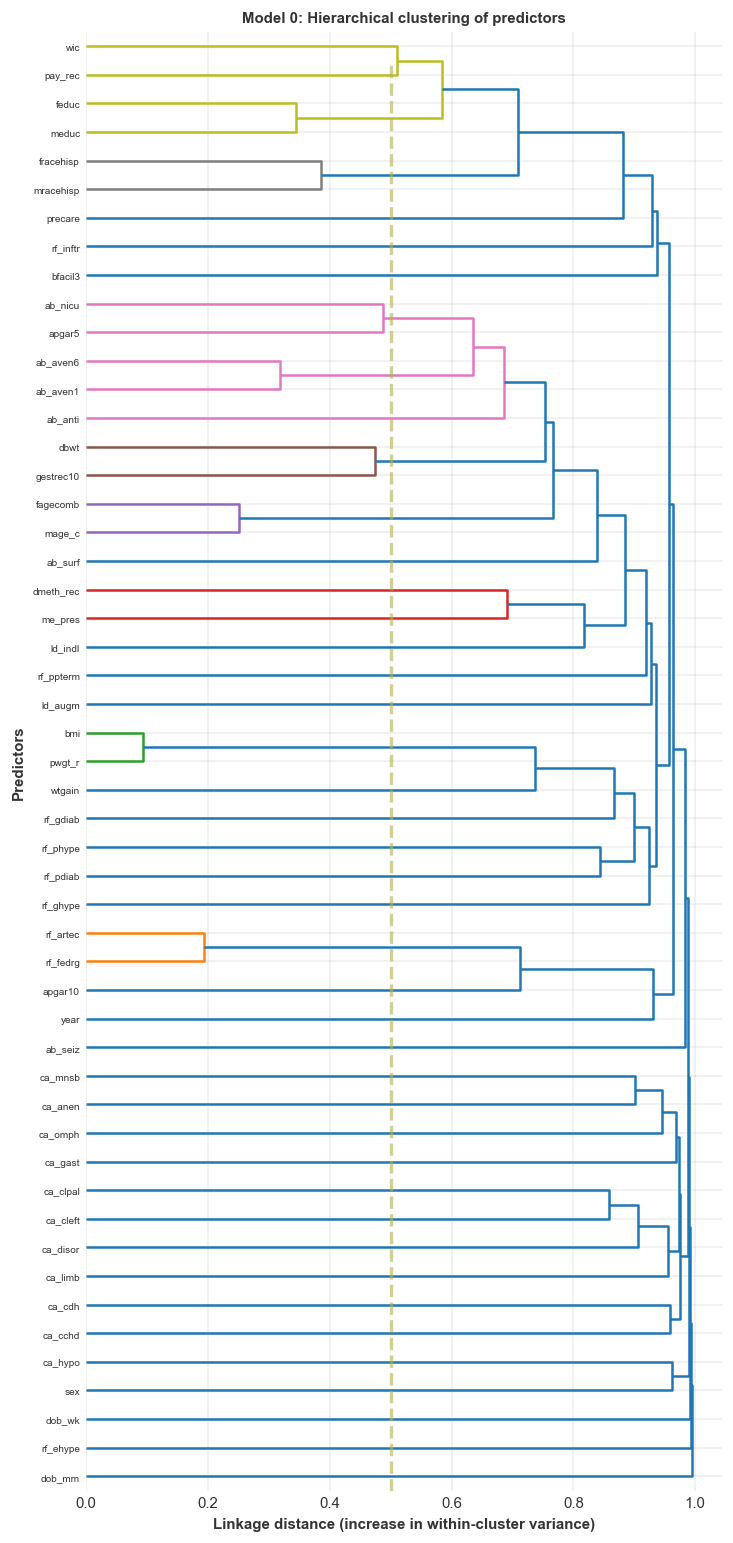

In [31]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

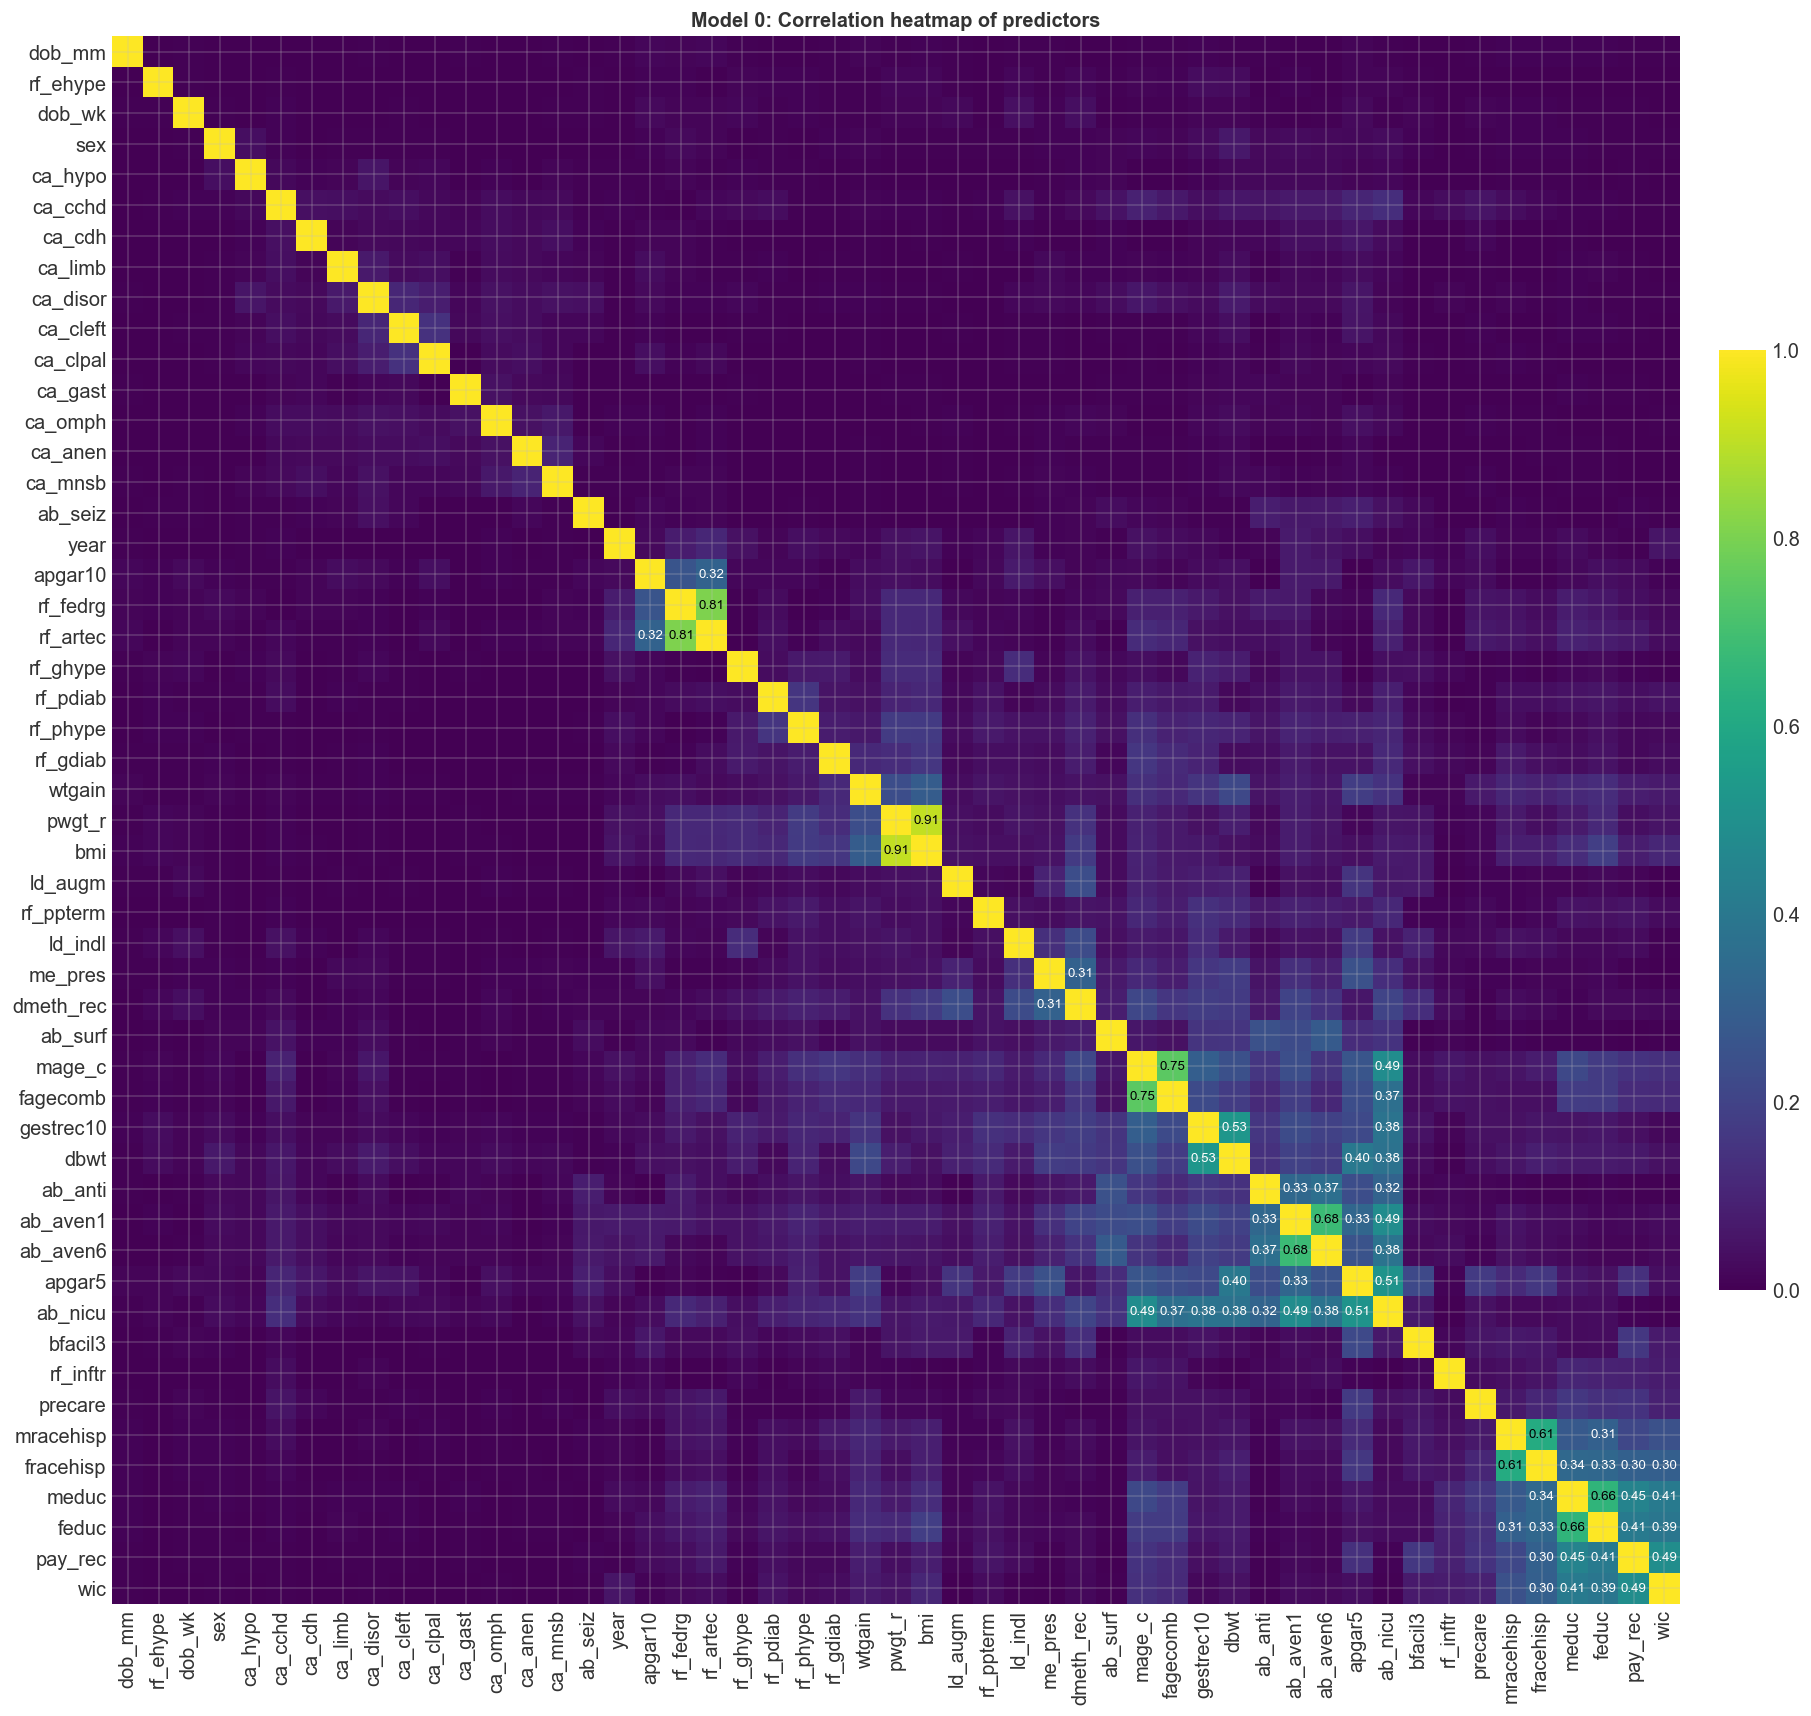

In [32]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [33]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
23,ab_nicu,0.866665
49,mage_c,0.719544
45,dbwt,0.322205
5,gestrec10,0.295972
21,ab_aven1,0.229903
29,ca_cchd,0.120277
37,ca_disor,0.108143
39,mracehisp,0.102719
50,fagecomb,0.083716
47,wtgain,0.079951


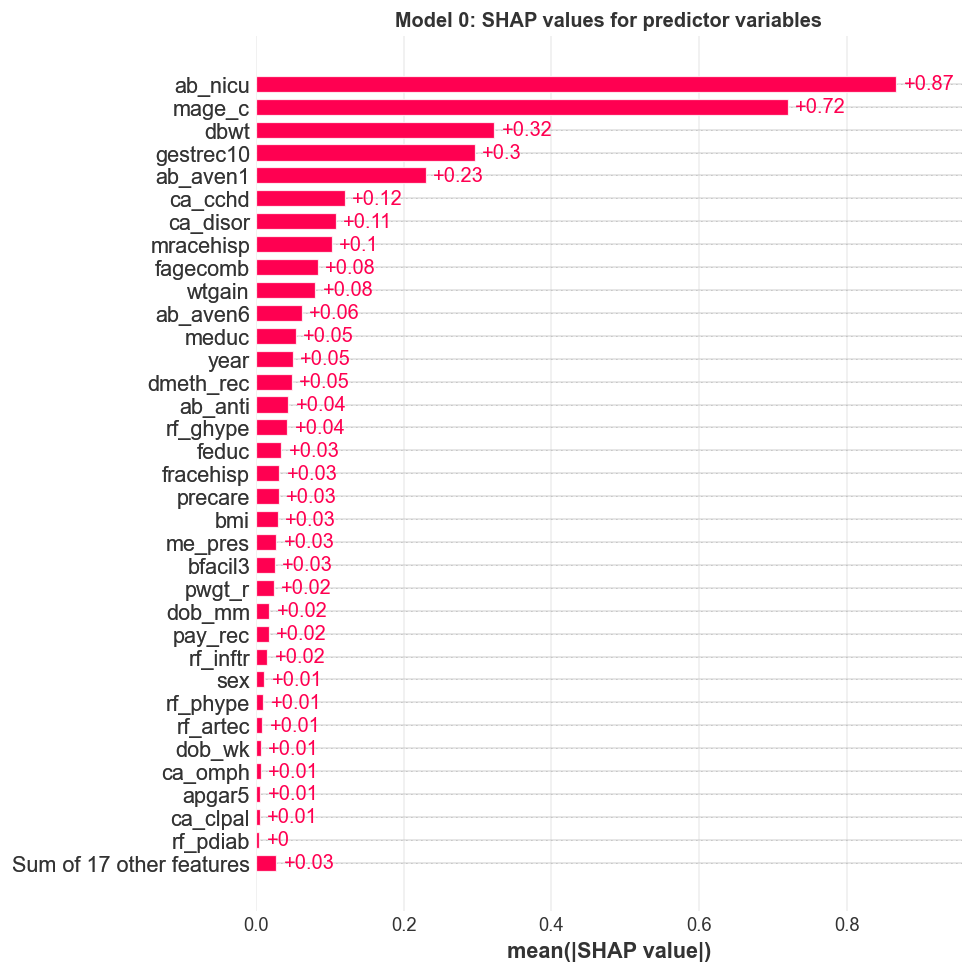

<Figure size 492x348 with 0 Axes>

In [34]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

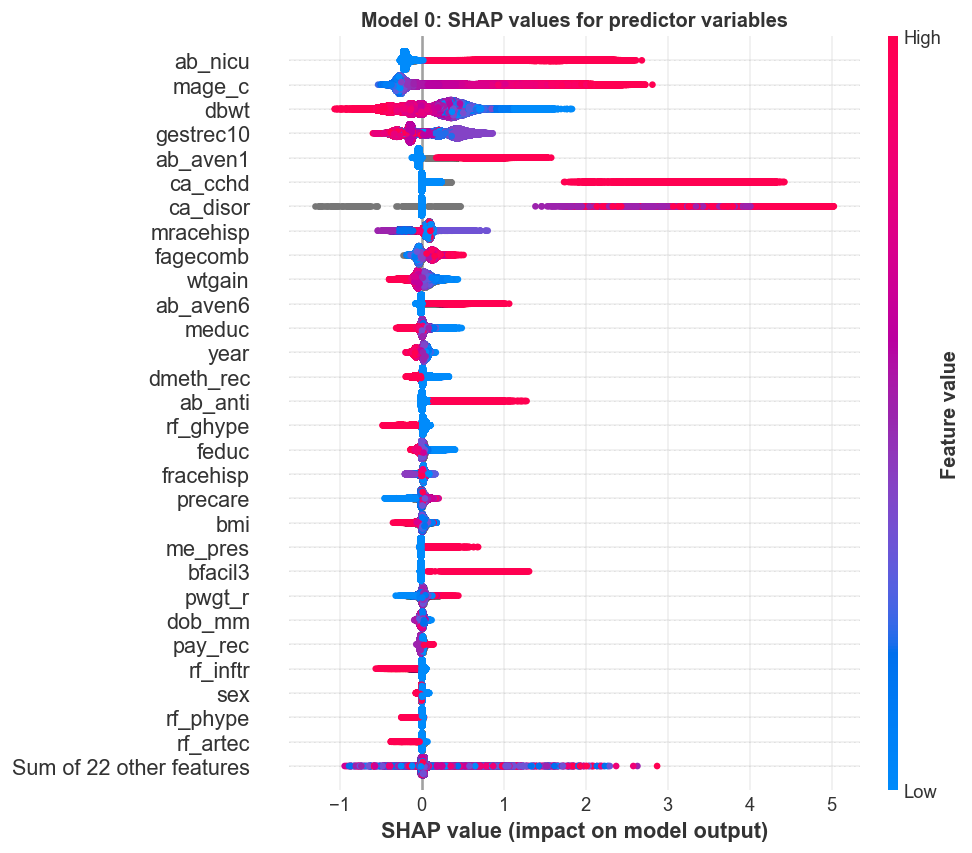

<Figure size 492x348 with 0 Axes>

In [35]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

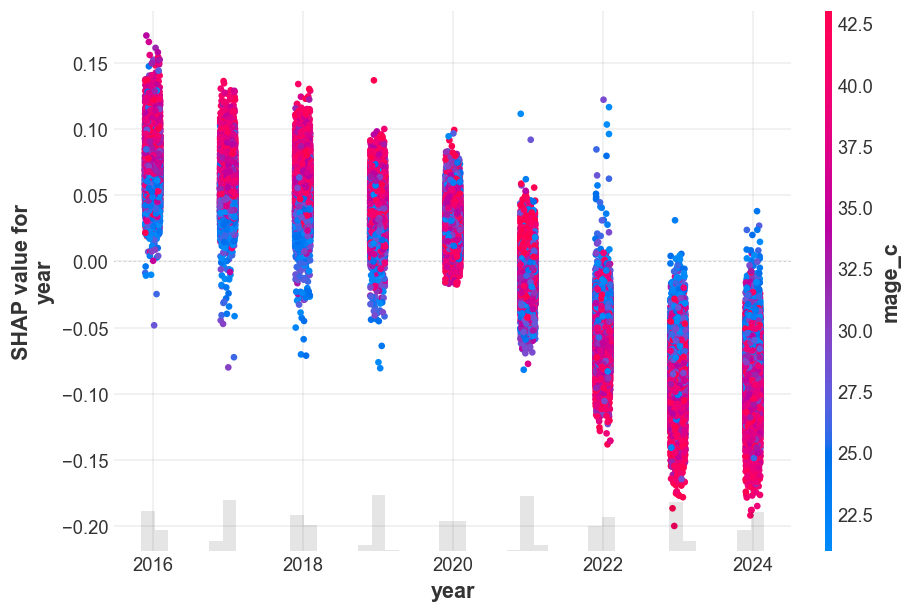

<Figure size 492x348 with 0 Axes>

In [36]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [ ]:
features_to_remove_0 = [
    "rf_inftr",
    "ca_cleft",
    "ca_cdh",
    "ca_omph",
    "ca_clpal",
    "rf_fedrg",
    "rf_artec",
    "ca_limb",
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)
X_cal = X_cal.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['rf_inftr', 'ca_cleft', 'ca_cdh', 'ca_omph', 'ca_clpal', 'rf_fedrg', 'rf_artec', 'ca_limb']
Features remaining: ['dob_mm', 'dob_wk', 'bfacil3', 'sex', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'apgar10', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_gast', 'ca_hypo', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'wic', 'year', 'dbwt', 'pwgt_r', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 8 predictors): 43


In [38]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.0228699	train's binary_logloss: 0.00418411	valid's average_precision: 0.0214075	valid's binary_logloss: 0.00419999
[20]	train's average_precision: 0.0282151	train's binary_logloss: 0.00401022	valid's average_precision: 0.0251532	valid's binary_logloss: 0.00403703
[30]	train's average_precision: 0.0304546	train's binary_logloss: 0.0039135	valid's average_precision: 0.0262447	valid's binary_logloss: 0.00394808
[40]	train's average_precision: 0.0322572	train's binary_logloss: 0.00384189	valid's average_precision: 0.0272428	valid's binary_logloss: 0.00388236
[50]	tr

In [39]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [40]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.888702
1,Validation AP,0.031403
2,Validation log loss,0.003621
3,Precision at 10000,0.080500
4,Recall at 10000,0.113014
5,Precision (threshold=0.01),0.030409
6,Recall (threshold=0.01),0.254668


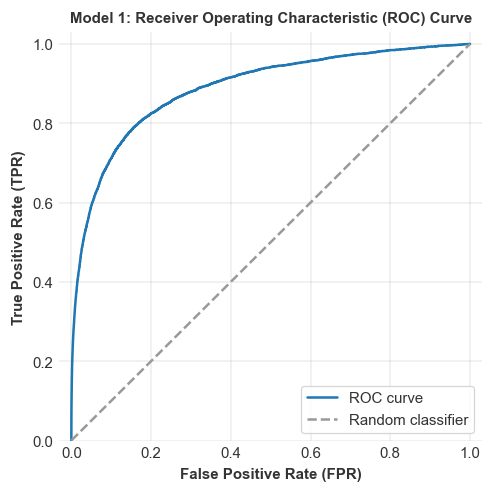

In [41]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

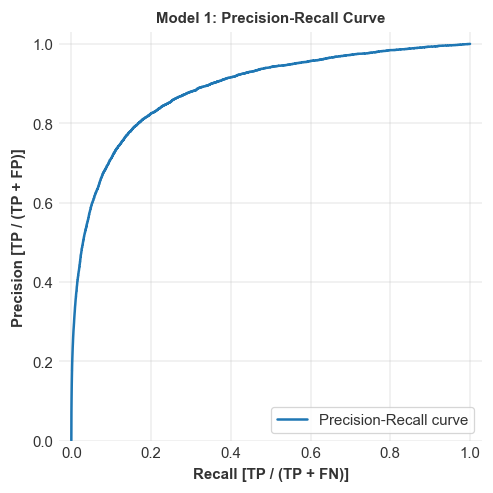

In [42]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [43]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
20,ab_nicu,205092.420866
41,mage_c,121158.450339
29,ca_disor,67720.177444
37,dbwt,61073.502468
26,ca_cchd,57111.864448
18,ab_aven1,38126.496682
42,fagecomb,37841.659007
5,gestrec10,35117.415100
39,wtgain,20372.943059
19,ab_aven6,18079.926426


In [44]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [45]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
29,ca_disor,0.011388,0.000311
26,ca_cchd,0.010678,0.000351
41,mage_c,0.007881,0.000398
37,dbwt,0.003648,0.000375
20,ab_nicu,0.002308,0.000456
5,gestrec10,0.001886,0.000226
15,dmeth_rec,0.001863,0.000232
42,fagecomb,0.001163,0.000304
39,wtgain,0.000876,0.000185
19,ab_aven6,0.000826,0.000228


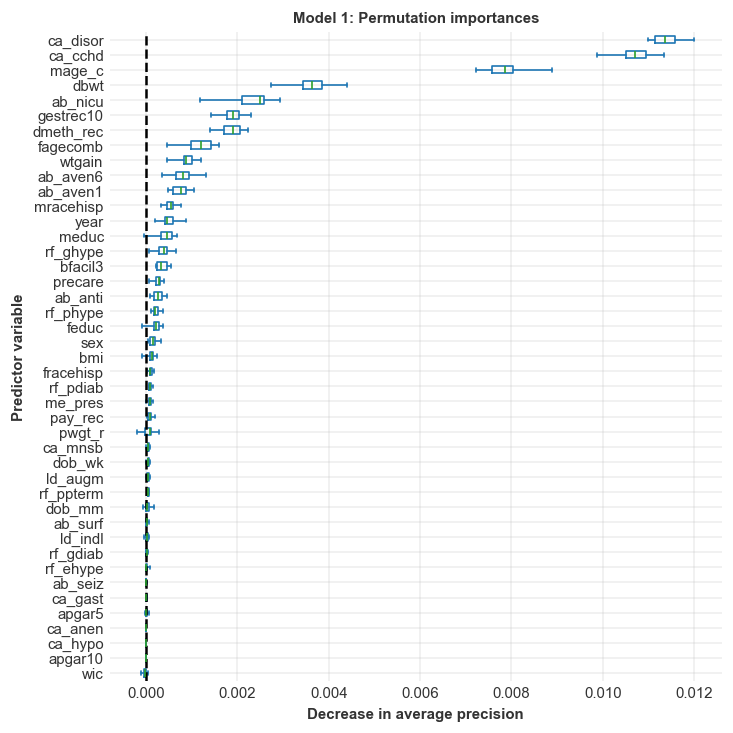

In [46]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

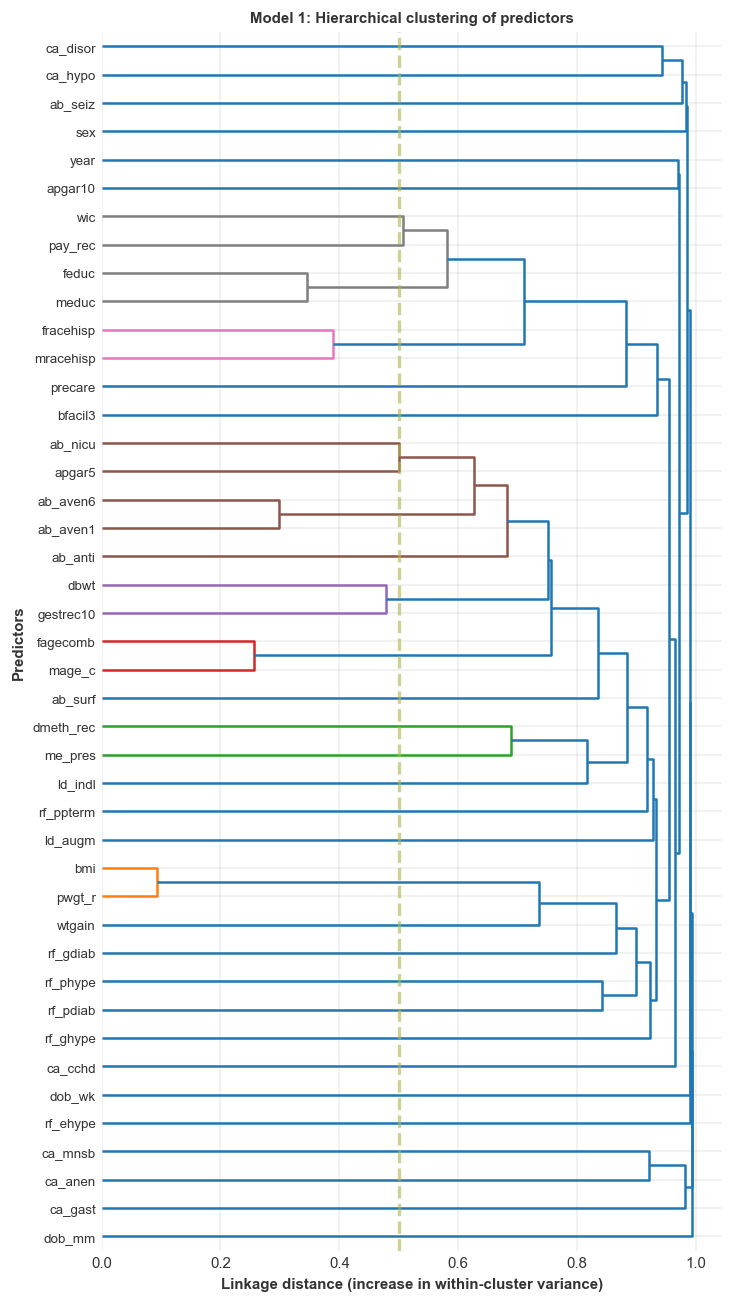

In [47]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

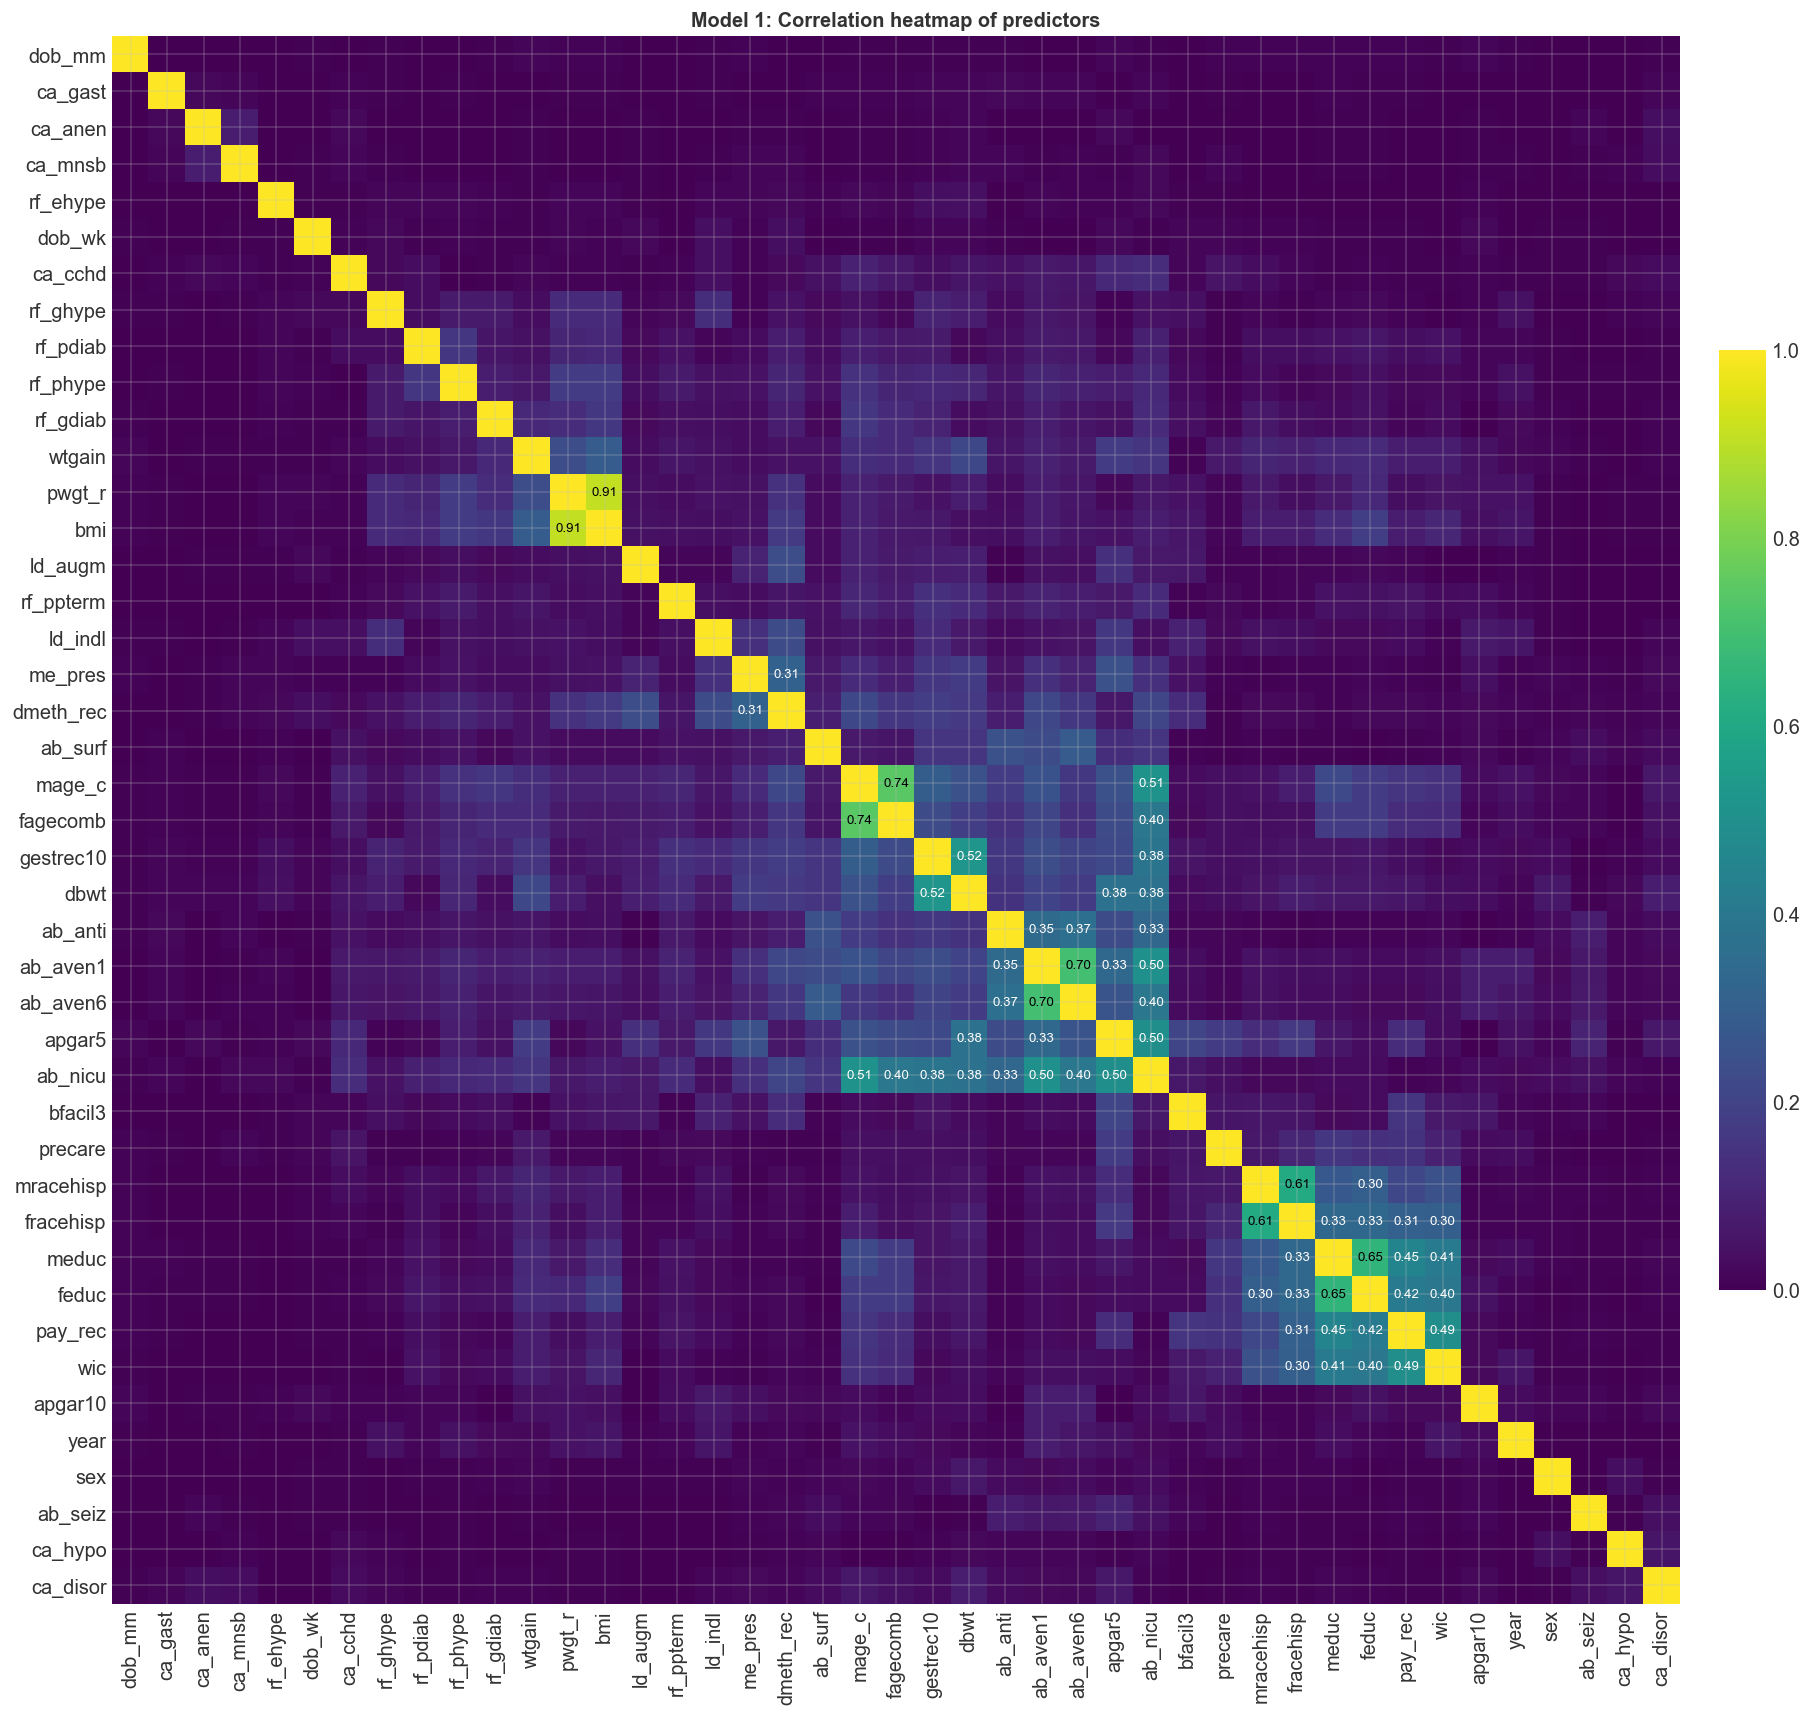

In [48]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [49]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
20,ab_nicu,0.822304
41,mage_c,0.656383
37,dbwt,0.289852
5,gestrec10,0.272870
18,ab_aven1,0.217714
26,ca_cchd,0.128231
42,fagecomb,0.121071
29,ca_disor,0.108269
31,mracehisp,0.087880
19,ab_aven6,0.077460


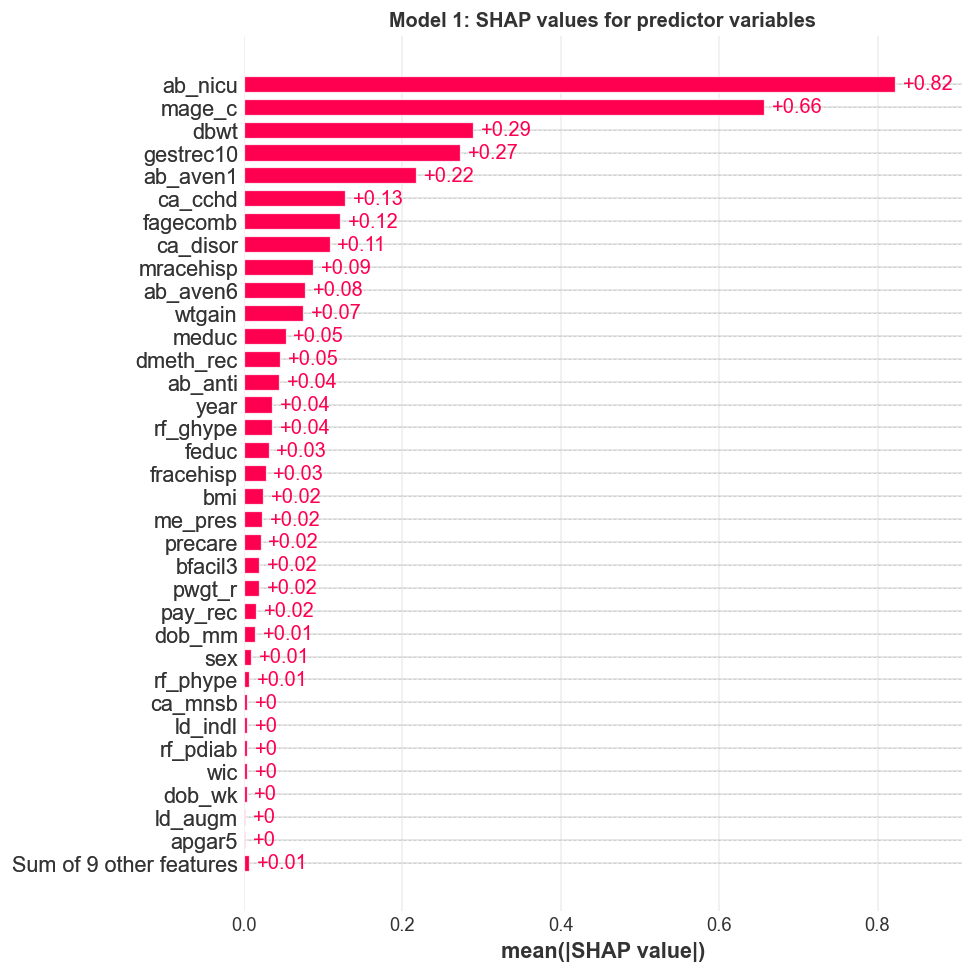

<Figure size 492x348 with 0 Axes>

In [50]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

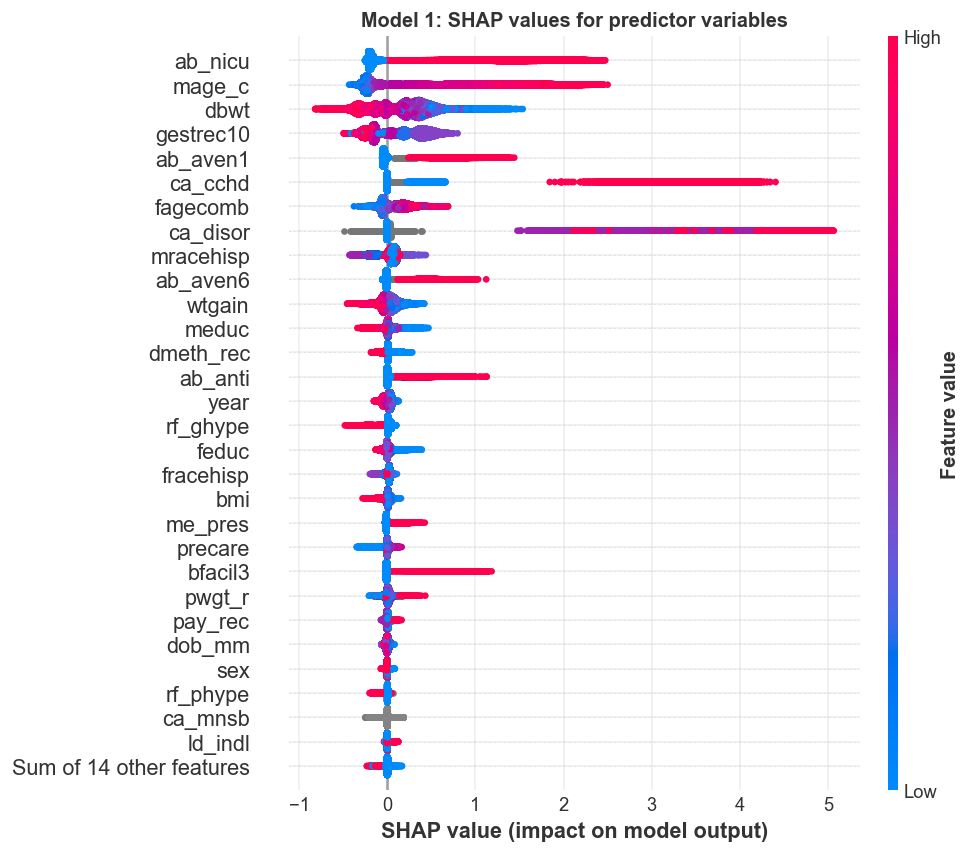

<Figure size 492x348 with 0 Axes>

In [51]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

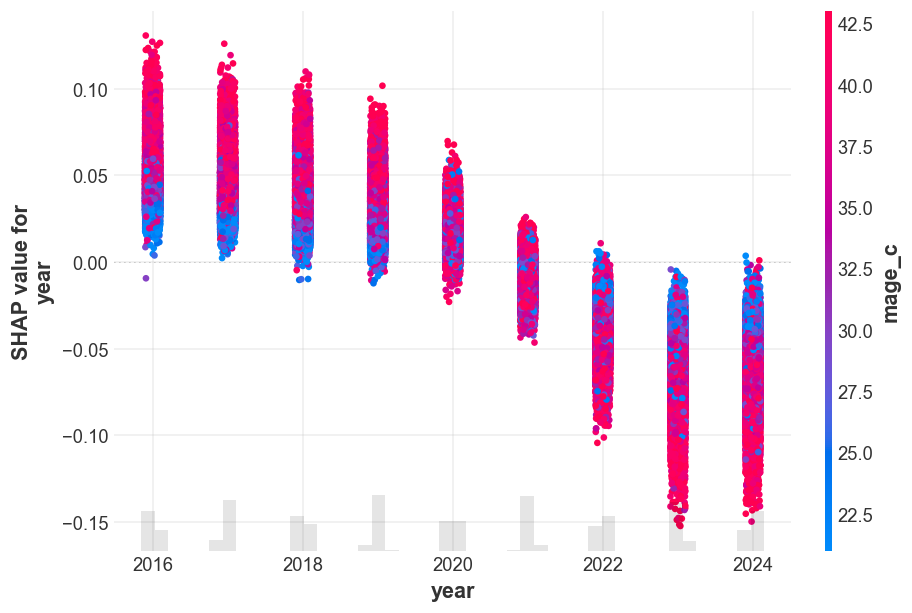

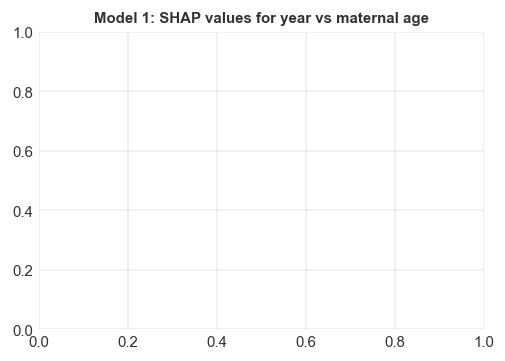

In [52]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [53]:
features_to_remove_1 = [
    "feduc",
    "fracehisp",
    "bmi",
    "me_pres",
    "precare",
    "bfacil3",
    "pwgt_r",
    "ca_hypo",
    "ca_anen",
    "apgar10",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)
X_cal = X_cal.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['feduc', 'fracehisp', 'bmi', 'me_pres', 'precare', 'bfacil3', 'pwgt_r', 'ca_hypo', 'ca_anen', 'apgar10']
Features remaining: ['dob_mm', 'dob_wk', 'sex', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'ld_indl', 'ld_augm', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_mnsb', 'ca_cchd', 'ca_gast', 'ca_disor', 'meduc', 'mracehisp', 'pay_rec', 'wic', 'year', 'dbwt', 'wtgain', 'mage_c', 'fagecomb']
Number of features in Model 2 (after removing 10 predictors): 33


In [54]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.024012	train's binary_logloss: 0.00417855	valid's average_precision: 0.0223261	valid's binary_logloss: 0.00419214
[20]	train's average_precision: 0.0278493	train's binary_logloss: 0.00402047	valid's average_precision: 0.0250815	valid's binary_logloss: 0.00404299
[30]	train's average_precision: 0.0312428	train's binary_logloss: 0.00391313	valid's average_precision: 0.0271053	valid's binary_logloss: 0.00394416
[40]	train's average_precision: 0.0328106	train's binary_logloss: 0.00384687	valid's average_precision: 0.0276679	valid's binary_logloss: 0.00388366
[50]	tra

In [55]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [56]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.888748
1,Validation AP,0.031235
2,Validation log loss,0.003618
3,Precision at 10000,0.081200
4,Recall at 10000,0.113997
5,Precision (threshold=0.01),0.028175
6,Recall (threshold=0.01),0.262389


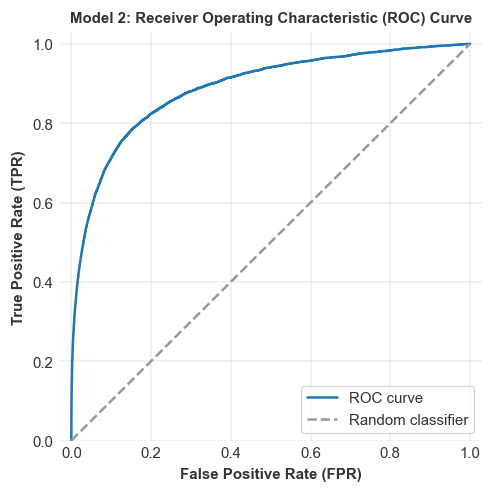

In [57]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

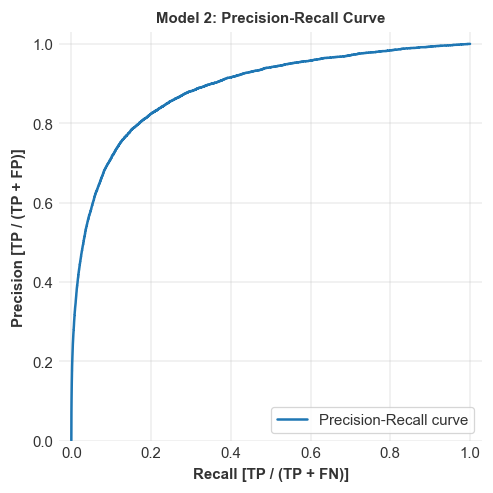

In [58]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [59]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
16,ab_nicu,214919.502131
31,mage_c,128569.668237
29,dbwt,77654.539889
23,ca_disor,73527.315103
21,ca_cchd,55582.933374
32,fagecomb,53231.926459
14,ab_aven1,39890.218040
3,gestrec10,37183.349500
30,wtgain,30818.068622
24,meduc,13142.525597


In [60]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [61]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
23,ca_disor,0.012055,0.000532
21,ca_cchd,0.010851,0.000366
31,mage_c,0.007890,0.000345
29,dbwt,0.003479,0.000286
3,gestrec10,0.002451,0.000275
16,ab_nicu,0.002316,0.000373
12,dmeth_rec,0.001859,0.000269
14,ab_aven1,0.001293,0.000176
32,fagecomb,0.000921,0.000280
30,wtgain,0.000829,0.000245


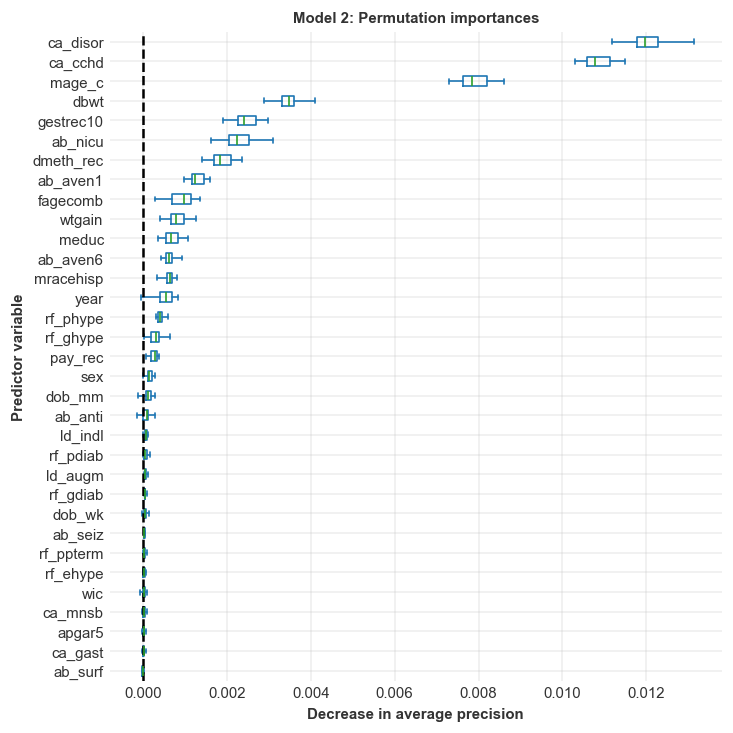

In [62]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

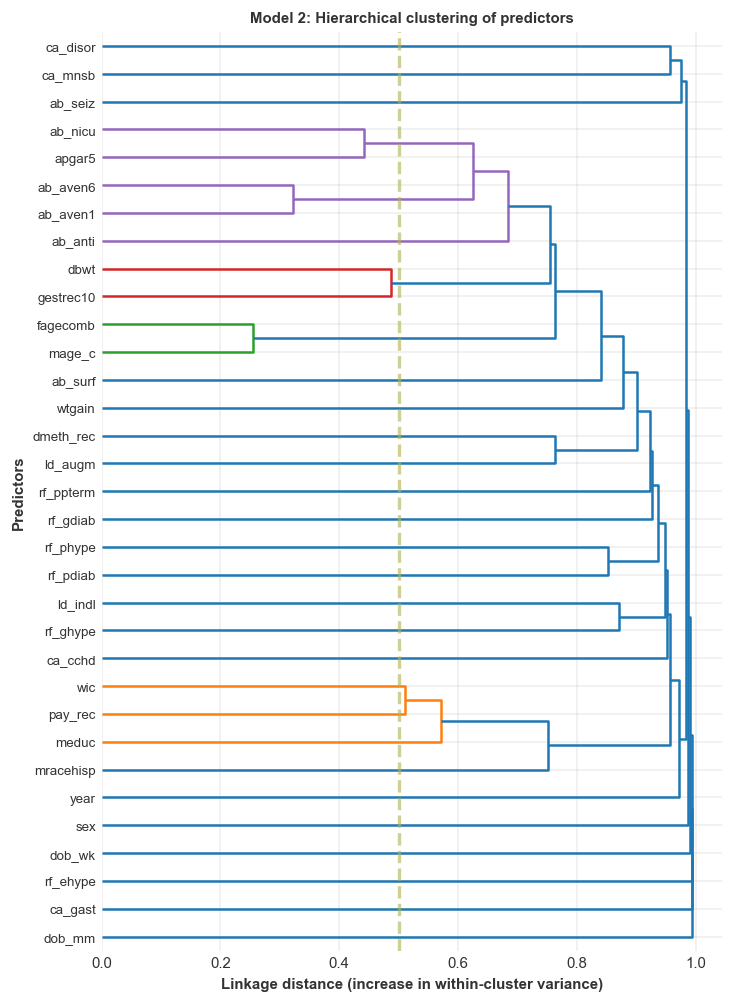

In [63]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

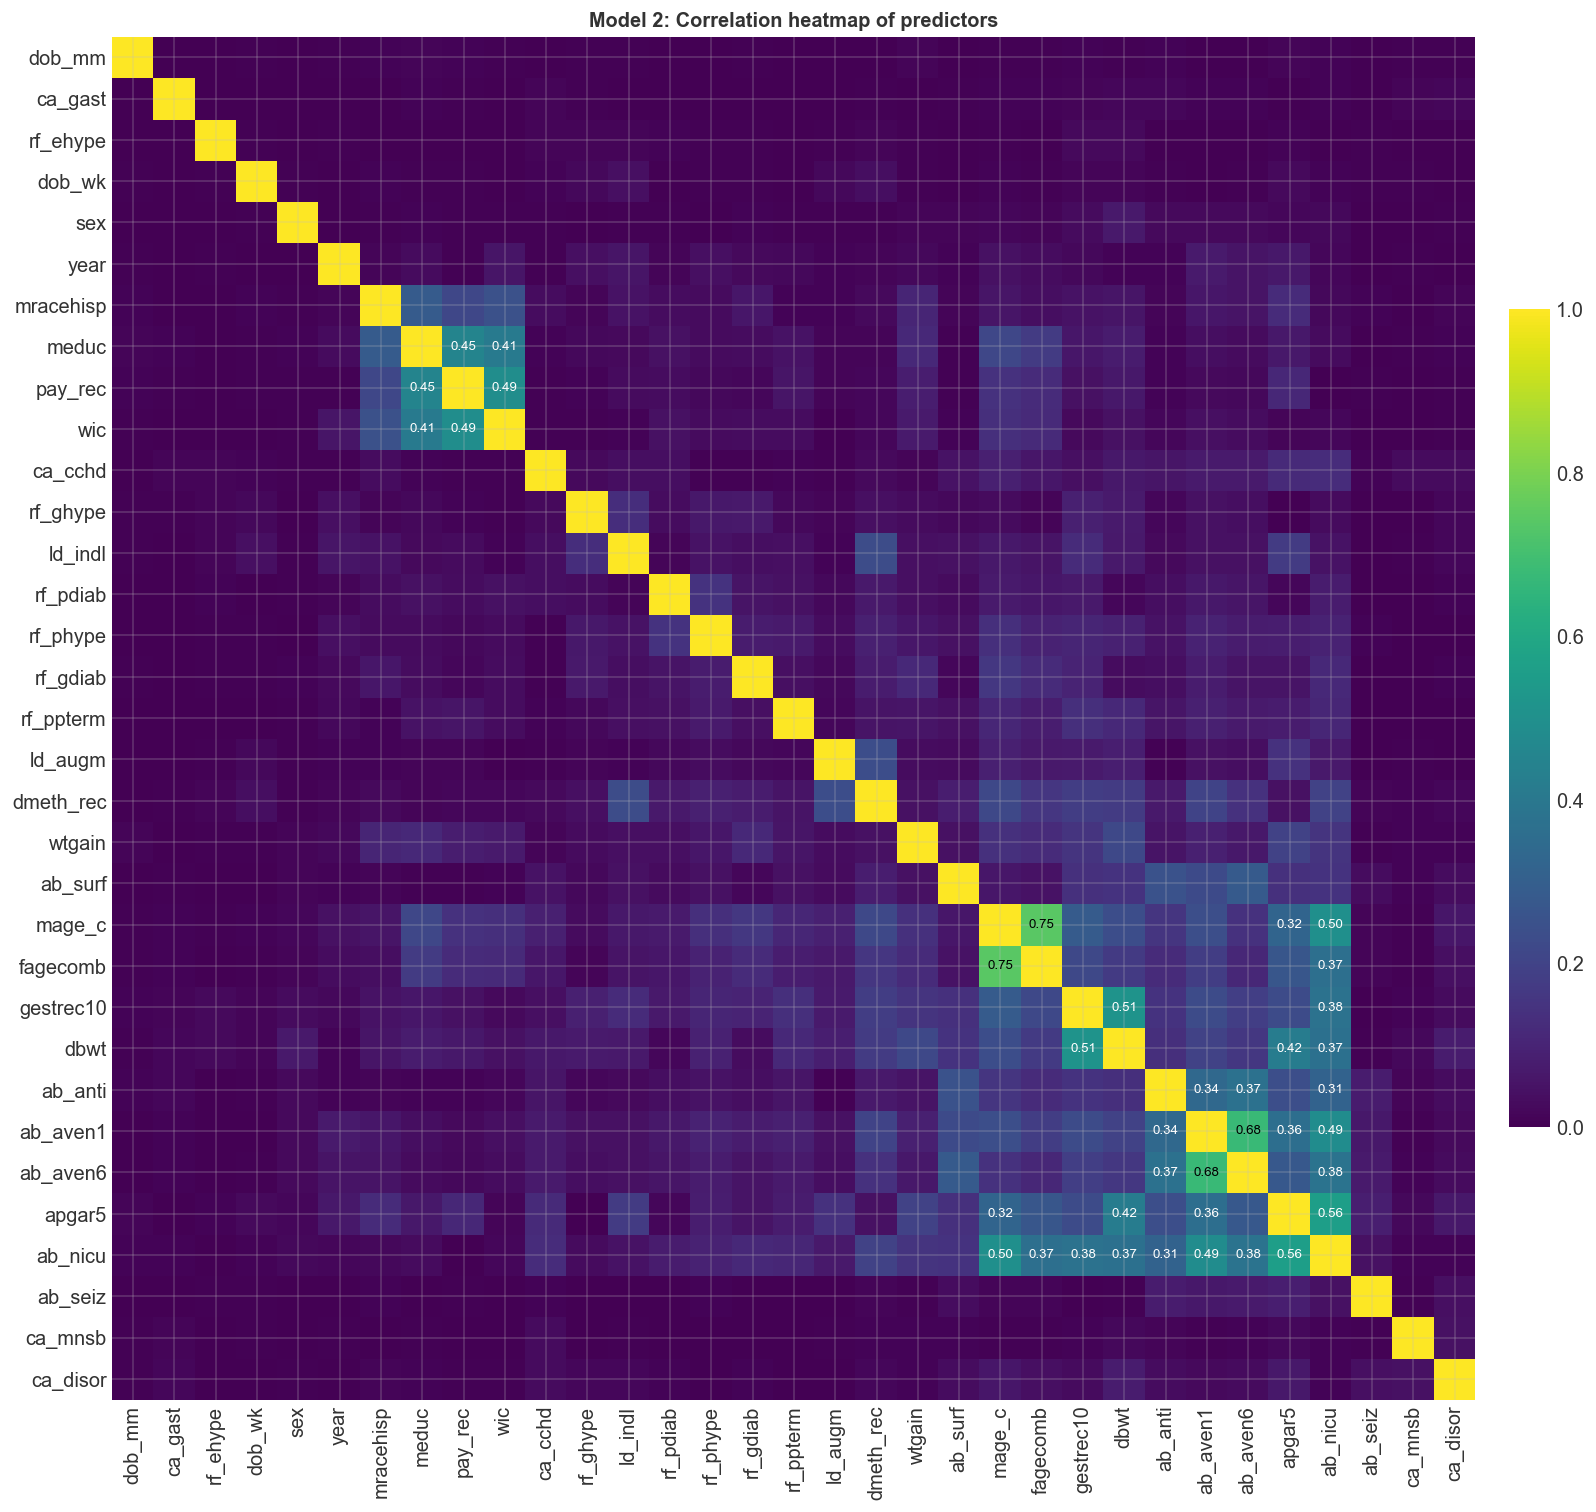

In [64]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [65]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
16,ab_nicu,0.885978
31,mage_c,0.748667
29,dbwt,0.348105
3,gestrec10,0.302726
14,ab_aven1,0.228976
25,mracehisp,0.138385
21,ca_cchd,0.125847
23,ca_disor,0.110743
32,fagecomb,0.097412
30,wtgain,0.086440


In [66]:
shap_importance["feature"].tolist()

['ab_nicu',
 'mage_c',
 'dbwt',
 'gestrec10',
 'ab_aven1',
 'mracehisp',
 'ca_cchd',
 'ca_disor',
 'fagecomb',
 'wtgain',
 'meduc',
 'ab_aven6',
 'year',
 'dmeth_rec',
 'rf_ghype',
 'pay_rec',
 'ab_anti',
 'dob_mm',
 'rf_phype',
 'sex',
 'dob_wk',
 'ld_augm',
 'ca_mnsb',
 'rf_pdiab',
 'apgar5',
 'wic',
 'ld_indl',
 'ca_gast',
 'rf_ehype',
 'ab_surf',
 'rf_ppterm',
 'rf_gdiab',
 'ab_seiz']

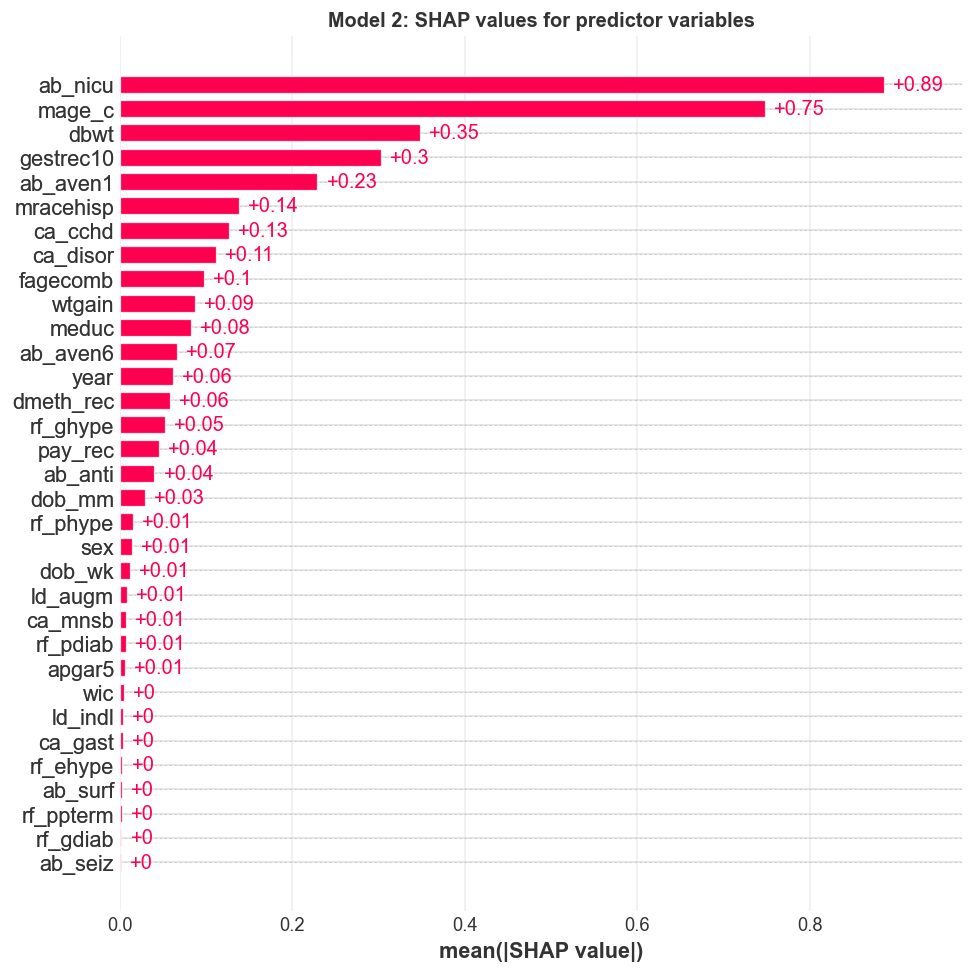

<Figure size 492x348 with 0 Axes>

In [67]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

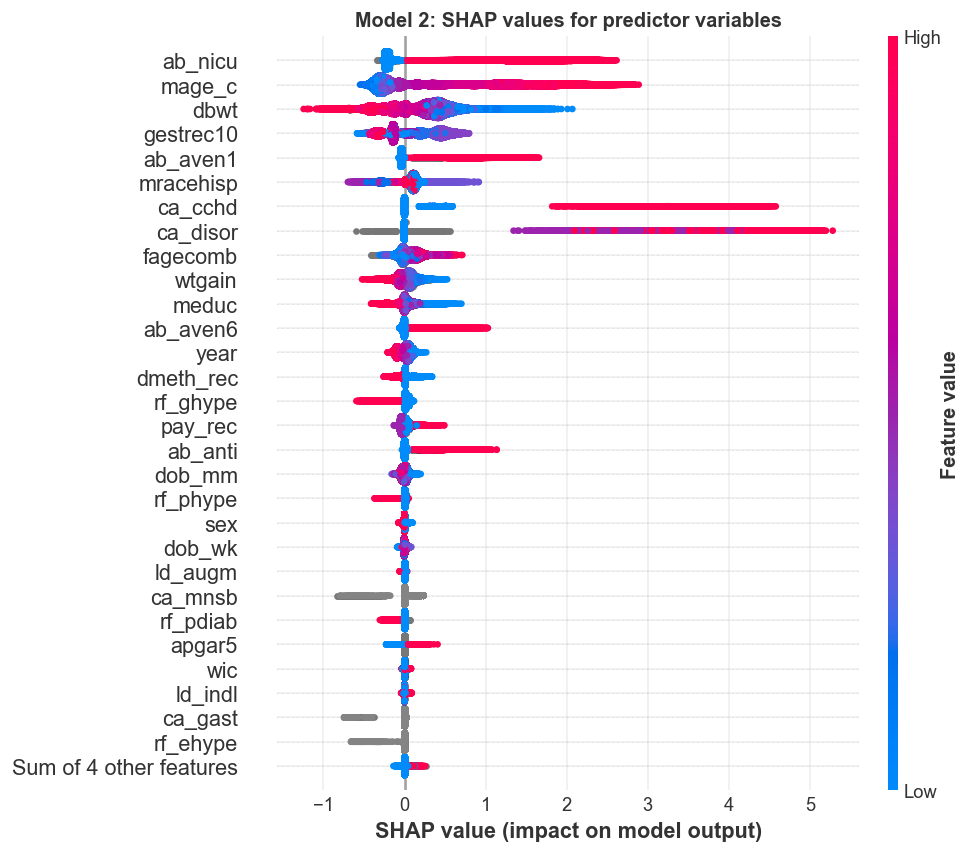

<Figure size 492x348 with 0 Axes>

In [68]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

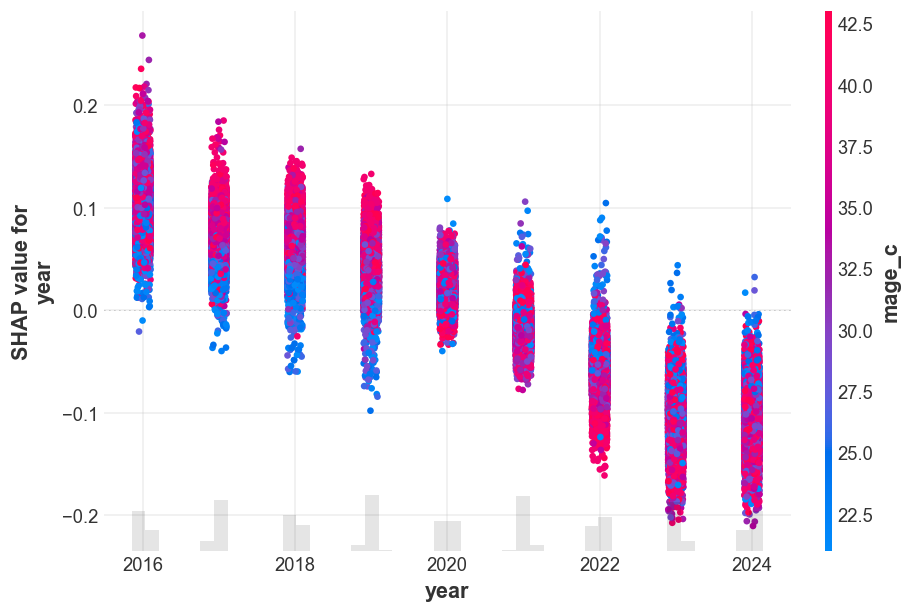

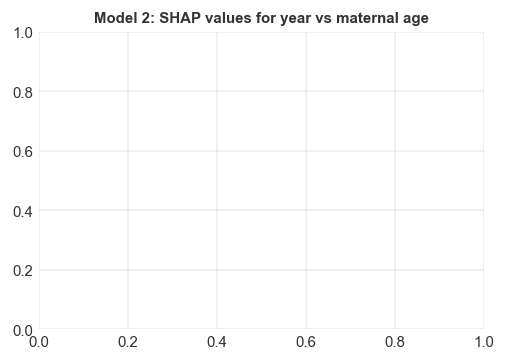

In [69]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Calibration


In [ ]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)

p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid_raw.mean()))
print("mean cal prob:", float(p_valid_cal.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))

In [ ]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [ ]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table_raw = tail_calibration_table(y_valid, p_valid_raw, fracs=fracs)
calibration_table_cal = tail_calibration_table(y_valid, p_valid_cal, fracs=fracs)

calibration_table_raw["model"] = "raw"
calibration_table_cal["model"] = "calibrated"
calibration_table_combined = pd.concat(
    [calibration_table_raw, calibration_table_cal], ignore_index=True
)

calibration_table_combined.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table_combined

In [ ]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
joblib.dump(calibrator, f"{OUTPUT_DIR}/final_calibrator.joblib")

meta = {
    "features": list(X_train.columns),
    "best_iteration": int(getattr(gbm, "best_iteration", 0) or 0),
    "calibration_input": "raw_score",  # or "prob"
}

joblib.dump(meta, f"{OUTPUT_DIR}/final_model_meta.joblib")

In [ ]:
X_full = df[features]
p_full_cal = predict_proba_calibrated(
    gbm, calibrator, X_full, num_iteration=gbm.best_iteration
)

In [ ]:
df["p_ds_lb_pred_01"] = p_full_cal

In [ ]:
df[["year", "p_ds_lb_pred"]].groupby("year").sum().reset_index()

In [ ]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [ ]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [ ]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [ ]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con.close()